In [1]:
# Install dependencies
!pip install matching

In [1]:
import numpy as np

In [2]:


        
def runExperiment(numUsers, userDim, steps, makeUsers, selectInteract, combinationFunc, config, logger=None):
    users = makeUsers(numUsers, userDim, config)
    #print(np.mean(users, axis=0))
    #print(users)
    for t in range(steps):
        prev = users
        users = combinationFunc(users, selectInteract(users, config), config)
        if not logger is None:
            logger(prev, users, t, config)
    return users
            

In [5]:
class ConfigHelper(object):
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)


In [6]:
# Averaging users
# Users start out by some distribution, then simply shift towards the other user they see. This ends them up at the average of all users
def randomSelectInteract(users, config):
    numUsers, userDim = users.shape
    randomPairing = np.arange(numUsers)
    np.random.shuffle(randomPairing)
    return users[randomPairing]
def normalDistrUsers(numUsers, userDim, config):
    return np.random.normal(0, 1, [numUsers, userDim])
def shiftTowards(users1, users2, config):
    return users1*(1-config.weightShifted)+users2*config.weightShifted


config = ConfigHelper(weightShifted=0.4)

runExperiment(10, 1, 1000, normalDistrUsers, randomSelectInteract, shiftTowards, config)

[-0.44810183]
[[-1.5260651 ]
 [-0.89444909]
 [ 1.81029703]
 [ 0.94763356]
 [-0.18395567]
 [-0.53191644]
 [-0.92880347]
 [-1.04049572]
 [-1.91242993]
 [-0.22083348]]


array([[-0.44810183],
       [-0.44810183],
       [-0.44810183],
       [-0.44810183],
       [-0.44810183],
       [-0.44810183],
       [-0.44810183],
       [-0.44810183],
       [-0.44810183],
       [-0.44810183]])

In [7]:
# Q: How could you have a continuous representation but allow for meaningful weirdness? One option would be to show people to others based on how similar they are.
# One way: figure out some "optimal pairing" thing that pairs people to the person that is the most similar, instead of uniform
# This is just a stable roomates problem

# Makes a dictionary with preferences in sorted order based on dot product (highest dot product first, lowest dot product last)
def convertToRoomatePreferences(users):
    numUsers, userDim = users.shape
    userPreferences = {}
    for i in range(numUsers):
        indicesExceptMe = np.arange(numUsers)!=i
        otherUsers = users[indicesExceptMe] # everyone except this user
        otherUserIndices = np.arange(numUsers)[indicesExceptMe]
        user = users[i]
        # sort other users by preference (high dot product = high preference)
        # we need to look up the indices, since otherwise due to argmax they'd be shifted since we don't have this user
        preferences = otherUserIndices[np.argsort(-(user*otherUsers).sum(axis=1))]
        userPreferences[i] = list(preferences)
    return userPreferences


import matching
from matching.games import StableRoommates

# Uses stable roomates to find matching of users that are closest
def optimalSelectInteract(users, config):
    numUsers, userDim = users.shape
    stable = StableRoommates.create_from_dictionary(convertToRoomatePreferences(users))
    matches = stable.solve()
    # Need to lookup player object by name
    playerMap = {}
    for p in matches._data.keys():
        playerMap[p.name] = p
    # return users indexed by the found matching
    return users[list([matches[playerMap[i]].name for i in range(numUsers)])]


config = ConfigHelper(weightShifted=0.4)
# This results in the pairings converging together because the same pairing will be chosen every time
runExperiment(10, 1, 1000, normalDistrUsers, optimalSelectInteract, shiftTowards, config)



[-0.11830058]
[[ 0.31557979]
 [ 0.49884256]
 [-0.67829403]
 [-0.8375181 ]
 [ 1.00101023]
 [-0.49983436]
 [ 0.35762566]
 [-1.61168039]
 [-0.07851797]
 [ 0.3497808 ]]


array([[ 0.11853091],
       [ 0.74992639],
       [-0.58906419],
       [-1.22459924],
       [ 0.74992639],
       [-0.58906419],
       [ 0.35370323],
       [-1.22459924],
       [ 0.11853091],
       [ 0.35370323]])

In [8]:

def shiftTowardsIfCloseAwayIfFar(users1, users2, config):
    resIfSameDir = users1*(1-config.weightShifted)+users2*config.weightShifted
    # we want x s.t. users1 + x = resIfSameDir
    # x = resIfSameDir - users1
    shiftedAmountIfSameDir = resIfSameDir - users1
    # Then for "pushing away" we can just go in the opposite direction
    resIfOppositeDir = users1 - shiftedAmountIfSameDir
    dotProds = users1*users2
    # set to zero if it doesn't apply, then we can just add them
    resIfSameDir[dotProds<=0] = 0
    resIfOppositeDir[dotProds>0] = 0
    #print(np.c_[resIfSameDir, resIfOppositeDir])
    #print(resIfSameDir + resIfOppositeDir)
    return np.clip(resIfSameDir + resIfOppositeDir, -1, 1)


config = ConfigHelper(weightShifted=0.9)

runExperiment(10, 10, 1000, normalDistrUsers, randomSelectInteract, shiftTowardsIfCloseAwayIfFar, config)

[-0.22936633  0.18699988  0.69988022 -0.18368317 -0.01712069  0.10184072
  0.22904438  0.27868473  0.08058839 -0.23063126]
[[ 0.16331687  0.51330568  2.47701257 -0.33792482  0.96566139  0.31229339
   0.75705029  1.36180461 -0.82064604 -1.39416766]
 [ 1.31771327  1.14335499  0.16990986 -1.09324122  0.24234964  0.50059641
   1.14659538  0.40340873  0.96844396 -0.48118283]
 [-0.95469533 -0.05169029 -0.8914035  -0.22339959 -0.64835258 -0.35658943
   0.65455619  0.53741454  1.2623993  -0.67647372]
 [-0.98380868  0.13037844  0.2815578  -0.86637249 -0.44443491  0.55862477
  -0.35631842  0.68890689 -1.66174446 -0.17033977]
 [-1.79069187  0.96010555  0.46186488  0.74080991  0.56445925 -0.11038007
   0.94558229  0.22403073  0.31934353  0.30172427]
 [ 0.03980894  0.3640322   1.23668139 -0.22635255  0.97987691  1.15237157
  -1.27090629 -0.17221722 -0.07317726  1.21164263]
 [ 2.03123715 -1.68076271  0.72386292  0.27956593 -0.92480888  0.0114607
  -0.23211249 -0.71667552  1.50015988 -0.68168429]
 [-

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.],
       [ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.],
       [-1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1.],
       [-1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.],
       [ 1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.],
       [-1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.],
       [ 1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.],
       [-1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.]])

In [9]:
def shiftTowardsButClamped(users1, users2, config):
    res = users1*(1-config.weightShifted)+users2*config.weightShifted
    return np.clip(res, -1, 1)

def logger(users, prev, t):
    return
    if np.all(users == prev):
        print(f"unchanged at time {t}")
    else:
        print(f"changed at time {t}")

config = ConfigHelper(weightShifted=0.1)
runExperiment(10, 10, 1000, normalDistrUsers, randomSelectInteract, shiftTowardsIfCloseAwayIfFar, config, logger)


[-0.3664647   0.4275934  -0.3990657  -0.34092122  0.49617422  0.05398624
 -0.04044082  0.28914354  0.00237179  0.3155842 ]
[[-1.6114752   0.8205781  -0.43410772 -0.35632095  0.50042993  1.17638732
   0.06445888  0.65094252  0.7137279  -1.10470087]
 [ 0.79168754  1.77836991  0.59921617  0.595574    1.69652803 -0.25607807
   0.4781757   2.66445456 -1.60438405  0.24989667]
 [-0.18820424  0.32554552  0.23011246 -1.39477114  1.10950084  0.31894275
   0.04085876  1.2442328   0.28102823  0.21395596]
 [ 0.33709383  0.47984289 -0.13654436 -0.90670081 -0.10775829  0.91588972
   0.2960186   0.53610274  0.29670412 -0.4979399 ]
 [-1.18999502 -0.60368137  0.29414041 -1.29889313 -0.73315978 -1.51784772
   2.74911687  0.48350988  1.36541567  0.5346276 ]
 [-1.48936563 -0.54438335 -0.4911446  -1.4939716   0.46905149  0.62105579
  -1.06234807  0.00301385 -0.59047548  0.11449378]
 [ 0.17818735  1.1219483  -0.10175858  0.64338396 -0.92355402 -0.74426301
  -0.05815743 -1.23105607  0.5266673  -0.05726245]
 [

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.],
       [-1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.],
       [-1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.],
       [ 1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.],
       [ 1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.],
       [ 1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.]])

In [45]:
goods = []
zeros = []
bads = []

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [390]:
def normalizedUsers(numUsers, userDim, config):
    ayy = np.random.normal(0, 1, [numUsers, userDim])
    ayy[:,0] = 0
    ayy[:,1] = 0
    ayy = clampNormsUsers(ayy)
    ayy[:,0] = ayy[:,2]
    ayy[:,1] = ayy[:,3]
    print(ayy)
    return ayy

usersAyyStart = normalizedUsers(10, 4, None)

[[-0.46125789 -0.88726612 -0.46125789 -0.88726612]
 [-0.16277396 -0.75465929 -0.16277396 -0.75465929]
 [-0.49491533  0.16846544 -0.49491533  0.16846544]
 [ 0.23009254  0.97316875  0.23009254  0.97316875]
 [-0.11470842  0.9933992  -0.11470842  0.9933992 ]
 [-0.90548873 -0.26534559 -0.90548873 -0.26534559]
 [ 0.93075631  0.36564011  0.93075631  0.36564011]
 [ 0.39303458  0.91952369  0.39303458  0.91952369]
 [-0.46939378  0.88298895 -0.46939378  0.88298895]
 [ 0.06130468  0.19528399  0.06130468  0.19528399]]


/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
No handles with labels found to put in legend.


[[-0.11405343199978744, -0.828659393033529, -0.46125788825936087, -0.8872661159531084], [0.0855704604954588, -0.4190625891637633, -0.1627739608763417, -0.754659290405678], [-0.5236155012395008, -0.3178350177212156, -0.49491532605661026, 0.16846543963862692], [-0.13617008493527175, 0.5987074634439434, 0.23009254365610599, 0.973168752762779], [-0.23575310608143166, 0.3888489579105643, -0.1147084205326393, 0.9933992038747097], [-0.8040337751744884, -0.57905309403444, -0.9054887284476192, -0.2653455945099765], [0.3263090084350577, 0.259929730721681, 0.9307563112523165, 0.36564010866421764], [0.11593123906266248, 0.4148671009074345, 0.39303458410142417, 0.9195236895807636], [-0.7555881483546715, 0.5053055192140579, -0.4693937804523432, 0.8829889460648176], [0.09054259779567755, 0.1100931789583836, 0.06130467675404175, 0.19528399135474692]]
[[-0.11405343 -0.82865939 -0.46125789 -0.88726612]
 [ 0.08557046 -0.41906259 -0.16277396 -0.75465929]
 [-0.5236155  -0.31783502 -0.49491533  0.16846544]


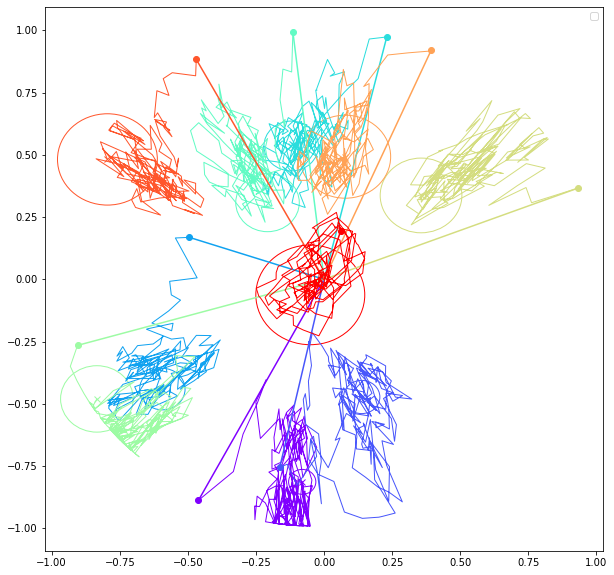

In [447]:


def normalizeUsers(users):
    return users / np.linalg.norm(users, ord=2, axis=1, keepdims=True)

def clampNormsUsers(users):
    norms = np.linalg.norm(users, ord=2, axis=1, keepdims=True)
    norms[norms < 1.0] = 1.0
    return users/norms

def shiftTowardsIfCloseAwayIfFarBilinear(users1, users2, config):
    resIfSameDir = users1*(1-config.weightShifted)+users2*config.weightShifted
    # we want x s.t. users1 + x = resIfSameDir
    # x = resIfSameDir - users1
    shiftedAmountIfSameDir = resIfSameDir - users1
    # Then for "pushing away" we can just go in the opposite direction
    resIfOppositeDir = users1 - shiftedAmountIfSameDir
    numUsers, userDim = users1.shape
    dotProds = []
    # binlinear form user1 dot mat dot user2.T
    # if mat is identity, this is dot product, but it can also be more expressive
    for i in range(numUsers):
        user1 = users1[i].reshape(1, userDim)
        mulMat = config.bilinearMat
        user2 = users2[i].reshape(userDim, 1)
        dotProds.append(user1.dot(mulMat).dot(user2).flatten()[0])
    #print("dotProds", dotProds)
    dotProds = np.array(dotProds)
    # set to zero if it doesn't apply, then we can just add them
    resIfSameDir[dotProds<=0] = 0
    resIfOppositeDir[dotProds>0] = 0
    #print(np.c_[resIfSameDir, resIfOppositeDir])
    #print(resIfSameDir + resIfOppositeDir)
    res = resIfSameDir + resIfOppositeDir
    return clampNormsUsers(res)
    #return np.clip(resIfSameDir + resIfOppositeDir, -1, 1)

# f(x+a)-a is same as f(x), so this is no different, oops
def shiftTowardsIfCloseAwayIfFarBilinearWithBaseValues(users1Both, users2Both, config):
    shiftingUsers1 = users1Both[:,:2]
    shiftingUsers2 = users2Both[:,:2]
    baseUsers1 = users1Both[:,2:]
    baseUsers2 = users2Both[:,2:]
    users1 = baseUsers1 + shiftingUsers1
    users2 = baseUsers2 + shiftingUsers2
    users1 = shiftTowardsIfCloseAwayIfFarBilinear(users1, users2, config)
    res = users1Both.copy()
    res[:,:2] = (users1-baseUsers1)
    return res
    #return np.clip(resIfSameDir + resIfOppositeDir, -1, 1)

def shiftTowardsIfCloseAwayIfFarBilinearWithBaseValuesPr(users1Both, users2Both, config):
    shiftingUsers1 = users1Both[:,:2]
    shiftingUsers2 = users2Both[:,:2]
    baseUsers1 = users1Both[:,2:]
    baseUsers2 = users2Both[:,2:]
    users1 = shiftTowardsIfCloseAwayIfFarBilinear(shiftingUsers1, shiftingUsers2, config)
    users1 = users1*(1-config.baseShifted)+baseUsers1*config.baseShifted
    res = users1Both.copy()
    res[:,:2] = users1
    return res
    
    
# newShiftVector = oldShiftVector*(1-p)+p*newShiftVector
    
class SimStuck(Exception):
    pass

def loggerChanged(users, prev, t, config):
    sumGuise = np.abs(np.sum(users))
    if sumGuise > 100000 or sumGuise < 0.00001:
        raise SimStuck()
    if np.all(users == prev):
        config.numUnchanged += 1
        #print(f"unchanged at time {t}")
    else:
        config.numUnchanged = 0
        #print(f"changed at time {t}")
    if config.numUnchanged > 1000:
        raise SimStuck()
        
        
def logger(users, prev, t, config):
    config.history.append(users)
    #print(users)


def configUsers(numUsers, usersDim, config):
    return config.users
    
def normalizedUsers(numUsers, userDim, config):
    ayy = np.random.normal(0, 1, [numUsers, userDim])
    ayy[:,0] = 0
    ayy[:,1] = 0
    ayy = clampNormsUsers(ayy)
    ayy[:,0] = ayy[:,2]
    ayy[:,1] = ayy[:,3]
    print(ayy)
    return ayy
    
#for i in range(1000):
userDim = 4
numUsers = 10
bilinearMat = np.random.normal(0, 1, [userDim, userDim])
bilinearMat = np.array([[ 0.2350428,   1.23881138],
 [-1.38685892, -0.46490194]])
#print(bilinearMat)

users = usersAyyStart

config = ConfigHelper(weightShifted=0.1, baseShifted=0.08, bilinearMat=bilinearMat, numUnchanged=0, history=[], users=users)
try:
    resUsers = runExperiment(numUsers, userDim, 200, configUsers, randomSelectInteract, shiftTowardsIfCloseAwayIfFarBilinearWithBaseValuesPr, config, logger)
    print([list(x) for x in resUsers])
    print(resUsers)
    print(bilinearMat, "wow")
    print("det", np.linalg.det(bilinearMat))
    print("eig", np.linalg.eig(bilinearMat))
    if np.sum(np.abs(resUsers)) < 0.00001:
        zeros.append(bilinearMat)
    else:
        goods.append(bilinearMat)
except SimStuck as e:
    #print(bilinearMat, "failed")
    #print("det", np.linalg.det(bilinearMat))
    bads.append(bilinearMat)
    pass


def getTimeUntilFinalPos(userI, history):
    if len(history) <= 1: return 0
    finalPos = 0
    prevPos = history[0][userI]
    for t, users in enumerate(history[1:]):
        curPos = users[userI]
        # if we've moved since last recorded pos, update final pos and update prevPos
        # this ensures that even if we are making very small steps, eventually our travel will be far enough to notice since we don't update prevPos
        if np.linalg.norm(prevPos-curPos, ord=2) > 0.001:
            finalPos = t
            prevPos = curPos
    return finalPos

from matplotlib import pyplot as plt
def plotUsers(config):
    numUsers, userDim = config.history[0].shape
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, numUsers)]
    radiuses = np.linspace(0.05, 0.2, numUsers)
    shifts = np.linspace(0.9, 0.1, numUsers*2)
    fig, ax = plt.subplots(figsize=(10,10))
    vals, vecs = np.linalg.eig(config.bilinearMat)
    for i in range(len(vals)):
        val, vec = vals[i], vecs[i]
        # skip complex ones
        if val.imag != 0: continue
        hasComplex = False
        for j in range(len(vec)):
            if vec[j].imag != 0: hasComplex = True
        if hasComplex: continue
        vec = vec/np.linalg.norm(vec, ord=2, keepdims=True)
        #if val < 0:
        #    ax.plot([0,vec[0]], [0, vec[1]], color='black')
        #else:
        #    ax.plot([0,vec[0]], [0, vec[1]], color='blue')
    for i in range(numUsers):
        # only record the portion that we are moving, so it can be nicely spread out and easier to see
        actualHistoryLen = max(4, getTimeUntilFinalPos(i, config.history))
        print(actualHistoryLen)
        smoothShift = np.linspace(shifts[i*2], shifts[i*2+1], actualHistoryLen)
        userHistory = np.array([users[i]*smoothShift[t] for t, users in enumerate(config.history[:actualHistoryLen])])
        userHistoryNotShifted = np.array([users[i] for t, users in enumerate(config.history[:actualHistoryLen])])
        userX = userHistory[:,0]+userHistory[:,2]
        userY = userHistory[:,1]+userHistory[:,3]
        #ax.plot(userX[0], userY[0], "o", color=colors[i])
        #ax.plot(userX, userY, color=colors[i], linewidth=1)
        #ax.plot(userX[-1], userY[-1], "x", color=colors[i])
        
        ax.plot([0, userHistoryNotShifted[0,2]], [0, userHistoryNotShifted[0,3]], color=colors[i])
        
        userX = userHistoryNotShifted[:,0]#+userHistoryNotShifted[:,2]
        userY = userHistoryNotShifted[:,1]#+userHistoryNotShifted[:,3]
        ax.plot(userX[0], userY[0], "o", color=colors[i])
        ax.plot(userX, userY, color=colors[i], linewidth=1)
        ax.plot(userX[-1], userY[-1], "x", color=colors[i])
        circle1  = plt.Circle((userX[-1], userY[-1]), radiuses[i], color=colors[i], fill=False)
        ax.add_artist(circle1)
    leg = ax.legend()
    # get the lines and texts inside legend box
    leg_lines = leg.get_lines()
    # bulk-set the properties of all lines and texts
    plt.setp(leg_lines, )
    plt.show()
    
plotUsers(config)

In [95]:

negneg = [[ 1.21280715 -0.17796451]
 [-0.67824878  1.32630672]]

posNegativeBipolarButVaries = [[ 0.2843441,  -0.39715388],
 [-0.97645364, -0.1270265 ]]

coolConvergeToNonCenter = [[-0.07164218,  1.47509577],
 [-1.10495361,  0.71304374]]

chasing = [[ 0.2350428,   1.23881138],
 [-1.38685892, -0.46490194]]

prettyChasing = [[-0.25891218  1.53047078]
 [-1.18470046 -0.5808519 ]]

chaoticButMostlyAlongCenter = [[-0.10451687  2.8270357 ]
 [-0.75684089 -1.47861909]]

# TODO: Plot guise path
users = np.random.normal(0, 1, [10, 2])


/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [322]:
ayy = np.array([[-0.9374388504377447, 0.8706407486332693, 0.9040100796801201, 0.12880035382631735], [-0.8912422093041933, -1.0821927653746488, 0.9246710167893849, 0.08275166414350682], [0.21447377214911287, -1.0820389003614201, -0.18104502167315406, 0.08259779722346385], [-0.6010173538527716, -0.3253020055039949, 0.6344461329997246, -0.6741390966749898], [0.19111488482271213, 0.6778955214281954, -0.22454368663730054, 0.3215455799926141], [-0.10109699617718652, -0.6204045618140358, 0.13452577746577415, -0.3790365402933168], [-0.6290137517181548, -0.8683216504124391, 0.6624425057841783, -0.13111945260543845], [-0.1397642086072509, -0.5050678609739021, 0.17319300663856319, -0.49437324057344867], [-0.4948315660664196, -1.0786951197660737, 0.5282603187397429, 0.07925401670161317], [-0.060547927302943574, -0.1855403386626031, 0.09397674660305529, -0.8139007621733587]])

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [331]:
ayy[:,:2]+ayy[:,2:]

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-0.03342877,  0.9994411 ],
       [ 0.03342881, -0.9994411 ],
       [ 0.03342875, -0.9994411 ],
       [ 0.03342878, -0.9994411 ],
       [-0.0334288 ,  0.9994411 ],
       [ 0.03342878, -0.9994411 ],
       [ 0.03342875, -0.9994411 ],
       [ 0.0334288 , -0.9994411 ],
       [ 0.03342875, -0.9994411 ],
       [ 0.03342882, -0.9994411 ]])

In [330]:
x1, y1, z1, w1 = ayy[0]
x2, y2, z2, w2 = ayy[6]
x1 += z1
y1 += w1
x2 += z2
y2 += w2
x1*x2+y1*y2

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.999999999999999

In [164]:
[np.linalg.eig(x)[0] for x in goods]

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[array([ 0.85236631, -2.11696855]),
 array([-2.00368   ,  0.70602723]),
 array([-1.83247291,  0.37594094]),
 array([-1.32692671,  1.05440574]),
 array([-1.14462927,  1.36510685]),
 array([-1.35001256,  1.46105814]),
 array([-0.69796385,  0.7373926 ]),
 array([-1.03449834,  1.95706489]),
 array([ 2.0145826 , -0.72964909]),
 array([-1.96106252,  0.43383501]),
 array([ 1.18226425, -0.74582687]),
 array([-1.58347237,  0.96255317]),
 array([-1.64524529,  0.00589498]),
 array([ 0.43839266, -1.21137734]),
 array([-2.10350432,  0.05346599]),
 array([ 0.43844533, -0.60500813]),
 array([ 0.25192053, -1.89901827]),
 array([-0.16509587,  1.76264131]),
 array([-0.54192201+0.62062767j, -0.54192201-0.62062767j]),
 array([ 2.12092879e+00, -6.71314504e-04]),
 array([-0.32413451,  0.81780267]),
 array([-0.05397269+0.76983556j, -0.05397269-0.76983556j]),
 array([2.93596132, 0.04878791]),
 array([-0.17141709,  0.5438387 ]),
 array([ 1.82950458, -0.87094771]),
 array([-0.87671996,  0.04774081]),
 array([1.

In [80]:


userDim = 2
numUsers = 4
bilinearMat = goods[0]
#print(bilinearMat)
#print("det", np.linalg.det(bilinearMat))
#print("eig", np.linalg.eig(bilinearMat))
config = ConfigHelper(weightShifted=0.1, bilinearMat=bilinearMat, numUnchanged=0)
try:
    print(runExperiment(numUsers, userDim, 10000, normalDistrUsers, randomSelectInteract, shiftTowardsIfCloseAwayIfFarBilinear, config, loggerChanged))
    print(bilinearMat, "wow")
except SimStuck as e:
    print(bilinearMat, "failed")

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[ 0.11948837  0.06583591]
 [ 0.2299084   0.17096397]
 [ 0.20599157  0.14819337]
 [-1.         -1.        ]]
[[ 0.83362398  0.06537308]
 [ 0.84592913 -2.09822622]] wow


/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [135]:

users = np.random.normal(0, 1, [4, 4])

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:

# From https://www.nature.com/articles/s41599-019-0343-5
# a relationship between two traits is a score: 1 if they are compatible, -1 if they are incompatible
# There are 100 agents, each with an individual "cultural repertoire", having a subset of traits from the universe
# They start with no traits, but will slowly either acquire traits from the universe of traits, or through copying them from other agents
# Interactions look like this:
# 1. For each agent (the receiver), sample one other agent as a "cultural model"
#   Randomly select one of the traits, i, in its repertoire for display to the receiver
#   The receiver copies the trait with a probability determined by the average compatability score s of the trait with the receiver's current repertoire
#     If the receiver has no traits, s = 0
#   Probability of copying is determined by 1/(1+exp(-10*s))
#  10 was arbitrarily chosen, but values below 5 give the score a small influence and results weren't sensitive to things above that
# 2. Each agent invents a new trait with probability 0.001 (invents means "selects a trait from the universe and obtains it if it doesn't already have it")
# 3. Each agent dies with probability 0.01 (though 0.0025 provides more stability) and is replaced by a new naive agent

# one option: just have a pre-specified matrix of trait compatibilties, and each agent has a default affinity for every trait

# for traits, we can use tit-for-tat algorithms. Then can be constantly introduced over time, growing in size

numTraits = 20
traitMatrix = np.clip(np.random.normal(0, 1, [numTraits, numTraits]), -1, 1)
config = ConfigHelper(numTraits=numTraits, traitMatrix=traitMatrix)



def interactUsers(users1, users2, config):
    resUsers = []
    numUsers, userDim = users1.shape
    numTraits, _ = config.traitMatrix.shape
    traitIndexLookup = np.arange(numTraits)
    for i in range(numUsers):
        user1 = users1[i]
        user2 = users2[i]
        s = 0.0
        availableTraits = traitIndexLookup[user1==1] # get all indices where user has the trait
        if len(availableTraits) > 0:
            # 1. Randomly select one trait to "display" to the other user
            randomTrait = np.random.choice(availableTraits)
            compatabilities = np.sum(config.traitMatrix[trait1][user2==1]
                

def traitUsers(numUsers, userDim, config):
    return np.zeros([numUsers, userDim])



/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SyntaxError: invalid syntax (<ipython-input-126-f09ea39a7ae2>, line 26)

In [4]:
np.arange(4)[np.array([5,6,2, 5]) == 5]

array([0, 3])

In [84]:
users = np.random.random([4, 6])
users

array([[0.86701282, 0.84294248, 0.92500557, 0.59653969, 0.22788833,
        0.550036  ],
       [0.91282008, 0.27975259, 0.24810738, 0.08824584, 0.75125026,
        0.0065273 ],
       [0.73913925, 0.08258533, 0.90970609, 0.85146818, 0.69061477,
        0.54597442],
       [0.56588378, 0.13174201, 0.25497804, 0.36703337, 0.32849429,
        0.33089205]])

In [101]:
np.argsort((users[0]*(users)).sum(axis=1))


array([3, 1, 2, 0])

array([3.02823085, 1.48417632, 2.51756428, 1.31334806])